In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
def extract_files(source_path, target_path):
    zip_ref = zipfile.ZipFile(source_path,'r')
    zip_ref.extractall(target_path)
    zip_ref.close()

In [4]:
extract_files('F:/test1.zip','F:/')
extract_files('F:/train.zip','F:/')

In [5]:
filenames = os.listdir("F:/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()


,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [7]:
df.tail()


,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

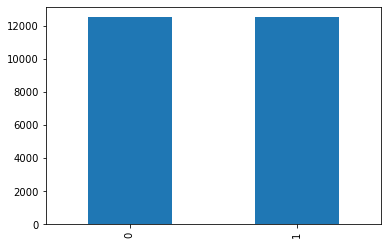

In [8]:
df['category'].value_counts().plot.bar()


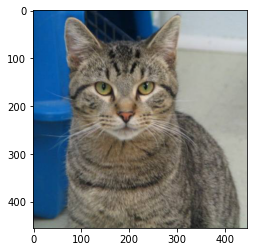

In [9]:
sample = random.choice(filenames)
image = load_img("F:/train/"+sample)
plt.imshow(image)

In [25]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               31490176  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [12]:
earlystop = EarlyStopping(patience=5)


In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [14]:
callbacks = [earlystop, learning_rate_reduction]

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 


In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


<AxesSubplot:>

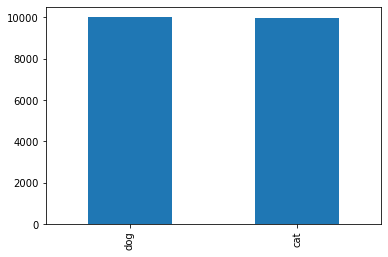

In [17]:
train_df['category'].value_counts().plot.bar()


<AxesSubplot:>

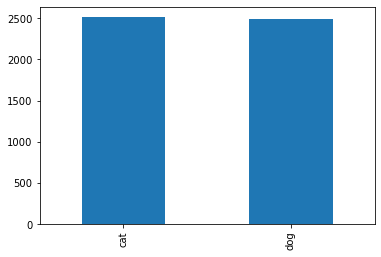

In [18]:
validate_df['category'].value_counts().plot.bar()


In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "F:/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "F:/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "F:/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


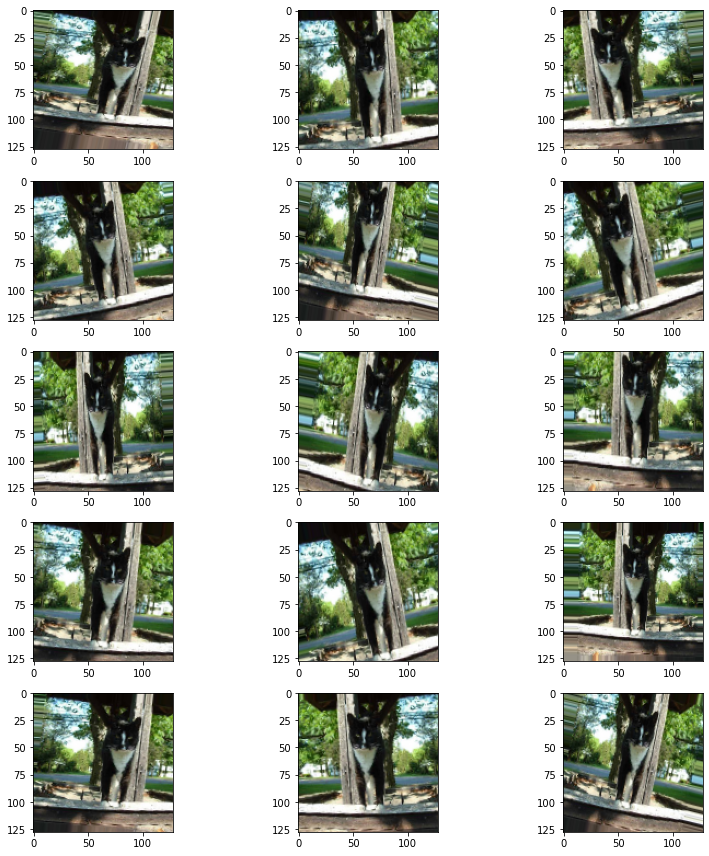

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [26]:
epochs=3 if FAST_RUN else 10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 1019s 763ms/step - loss: 0.7676 - accuracy: 0.6114 - val_loss: 0.6174 - val_accuracy: 0.6917
Epoch 2/10
1333/1333 [==============================] - 982s 736ms/step - loss: 0.6278 - accuracy: 0.6742 - val_loss: 0.5429 - val_accuracy: 0.7355
Epoch 3/10
1333/1333 [==============================] - 984s 738ms/step - loss: 0.6017 - accuracy: 0.6959 - val_loss: 0.5390 - val_accuracy: 0.7309
Epoch 4/10
1333/1333 [==============================] - 975s 731ms/step - loss: 0.5857 - accuracy: 0.7080 - val_loss: 0.5331 - val_accuracy: 0.7317
Epoch 5/10
1333/1333 [==============================] - 974s 731ms/step - loss: 0.5871 - accuracy: 0.7124 - val_loss: 0.5581 - val_accuracy: 0.7253
Epoch 6/10
1333/1333 [==============================] - 973s 730ms/step - loss: 0.5828 - accuracy: 0.7117 - val_loss: 0.6286 - val_accuracy: 0.7373
Epoch 7/10
1333/1333 [==============================] - 973s 730ms/step - loss: 0.5835 - accuracy: 0.7173 - val

In [27]:
model.save_weights("model5_Cnn.h5")

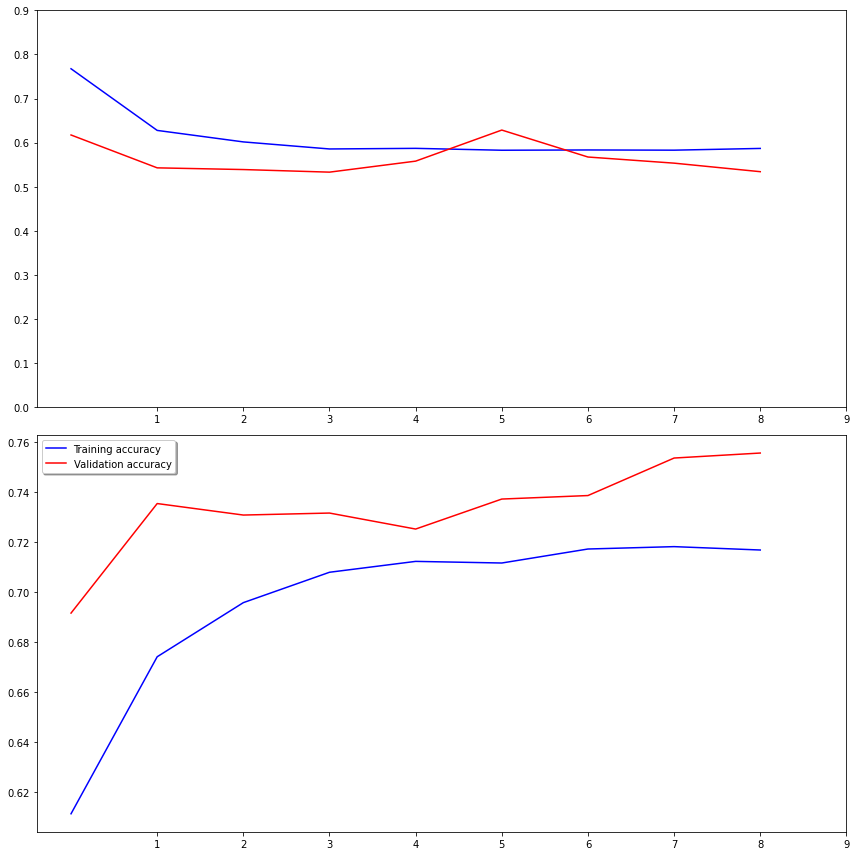

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [29]:
test_filenames = os.listdir("F:/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "F:/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [31]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [32]:
test_df['category'] = np.argmax(predict, axis=-1)

In [33]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [34]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })


<AxesSubplot:>

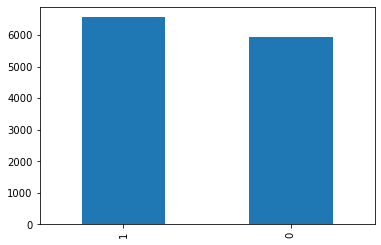

In [35]:
test_df['category'].value_counts().plot.bar()


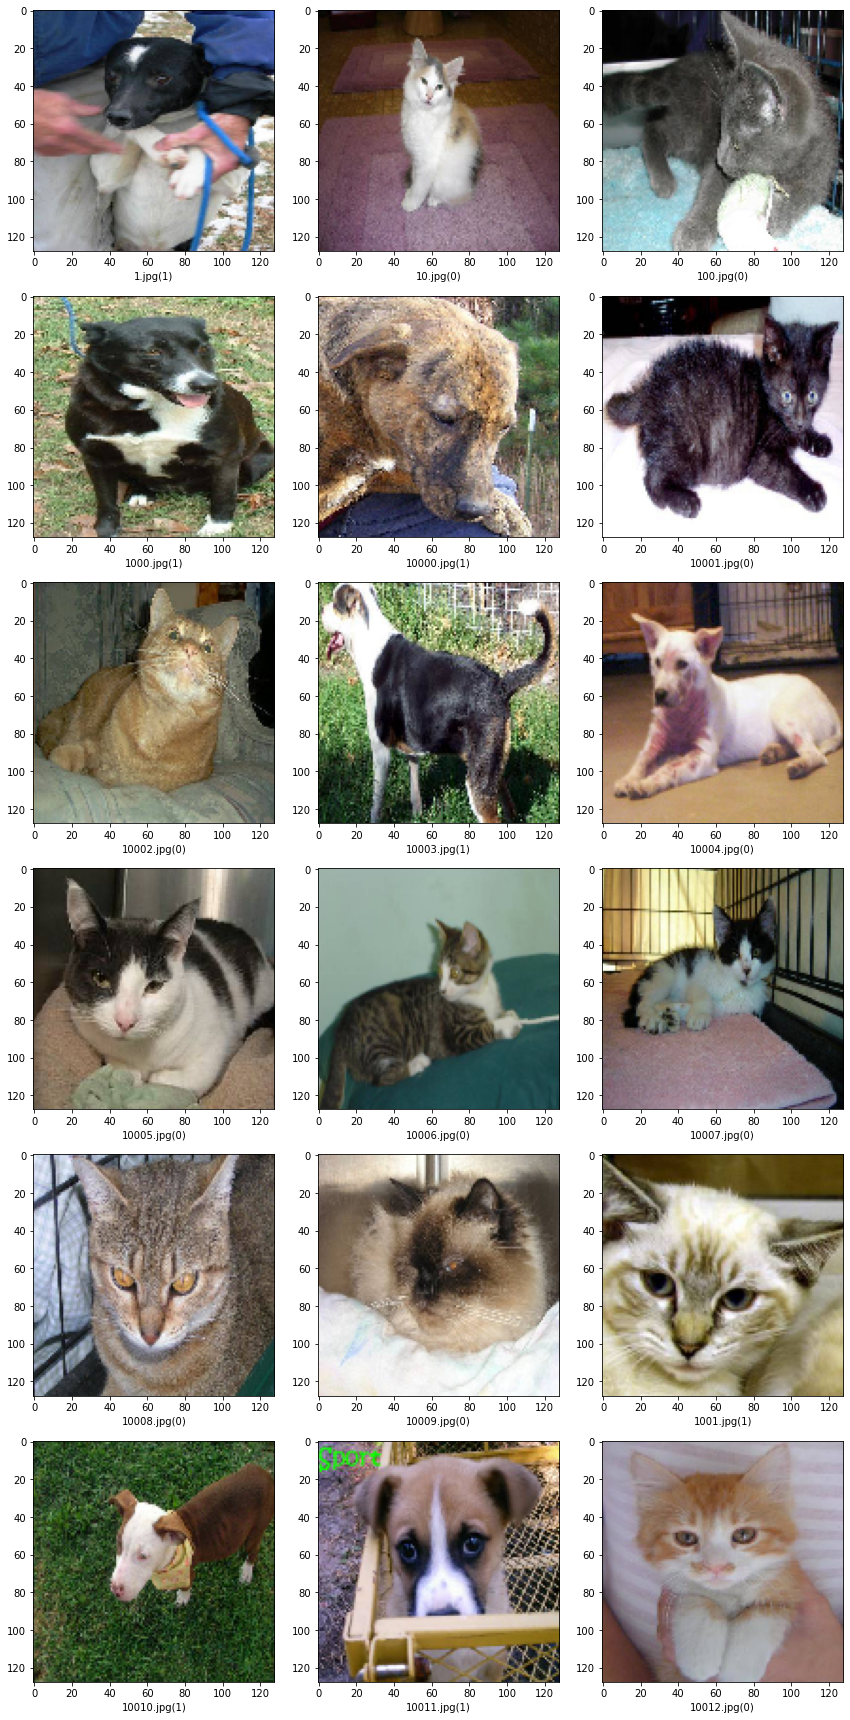

In [36]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("F:test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()


In [37]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_CD_cnn.csv', index=False)